# Clustering geografico + classificazione per cluster

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install pyspark
!pip install Nominatim
!pip install kneed

     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 198 kB 57.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=8bcf01bad617ab23cf08669f96aea54aff4fc2e3aad0936ad50065a566937edc
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
  Created wheel for Nominatim: filename=nominatim-0.1-py3-none-any.whl size=2363 sha256=b5b839d0d7b06562b8cf6ffe2e6c974046dee37d9cf602e81bd92e48fcd48a1d
  Stored in directory: /root/.cache/pip/wheels/37/00/9e/d904c390bfb174830ad3dcfd62af5544cee7d88bed4f8acedd
Successfully built Nominatim


In [ ]:
from pyspark.sql.functions import when, col, isnan, count,  regexp_replace, udf
import numpy as np
import pyspark
import re
from geopy.geocoders import Nominatim
from pyspark.sql.types import FloatType, DoubleType, StructType, StructField, StringType
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler,MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler, PCA
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col, max as _max, min as _min
import folium
import pyspark.sql.functions as F
from pyspark.ml.clustering import KMeans, BisectingKMeansModel, KMeansSummary
from  pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import ClusteringEvaluator
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from IPython.display import display
from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer, VectorIndexer, StandardScaler, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
import pandas as pd

In [ ]:
sc = pyspark.SparkContext()

In [ ]:
sqlCtx = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
spark = SparkSession.builder \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [ ]:
# load the dataset
rain_path = 'drive/My Drive/DDAM/Australia Rain/rain_tomorrow_australia_PROVA.csv'

In [ ]:
# carico il dataframe
df = spark.read.load(rain_path, format="csv", sep=",", inferSchema="true", header="true").drop("_c0")

Leggiamo il file come RDD con Spark


In [ ]:
rain_rdd = spark.sparkContext.textFile(rain_path)

In [ ]:
rain_rdd.take(5)

[',Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,Month,Season,Region',
 '0,01/12/2008,Albury,13.4,22.9,0.6,3.2,5.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,2.0,16.9,21.8,No,0.0,No,12,Winter,New South Wales',
 '1,02/12/2008,Albury,7.4,25.1,0.0,3.2,5.6,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,4.0,2.0,17.2,24.3,No,0.0,No,12,Winter,New South Wales',
 '2,03/12/2008,Albury,12.9,25.7,0.0,3.2,5.6,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,4.0,2.0,21.0,23.2,No,0.0,No,12,Winter,New South Wales',
 '3,04/12/2008,Albury,9.2,28.0,0.0,3.2,5.6,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,4.0,2.0,18.1,26.5,No,1.0,No,12,Winter,New South Wales']

In [ ]:
kdd_rain_header = rain_rdd.first()

In [ ]:
# take the first row and filter out the header
rdd_rain_no_header = rain_rdd.filter(lambda l: l!=kdd_rain_header).map(lambda l : l.split(","))

In [ ]:
# delete the first column c0_
rdd_rain_no_header = rdd_rain_no_header.map(lambda l: l[1:])

## Clustering

In [ ]:
def location_replace(location):
  if location == 'PearceRAAF':
    return 'Pearce RAAF'
  else:
    result = re.findall('.[^A-Z]*', location)
    if len(result) > 1:
      location_new = result[0] + ' ' + result[1]
      return location_new
    else:
      return location

In [ ]:
location_rdd = rdd_rain_no_header.map(lambda l: [location_replace(l[1])])

In [ ]:
# distinct location 
distinct_location = location_rdd.flatMap(lambda x: x).distinct()

In [ ]:
def get_coordinate(city):
  country = 'Australia'
  geolocator = Nominatim(user_agent="Group_DDAM")
  location = geolocator.geocode(city+','+ country,timeout=50)
  #tuple_location = (city,location.latitude,location.longitude)
  return city, location.latitude, location.longitude

In [ ]:
distinct_location_coord = distinct_location.map(get_coordinate)

In [ ]:
columns = ["Adress", "latitude", "longitude"]
location_coord_rdd_DF = distinct_location_coord.toDF(columns)
location_coord_rdd_DF.show(5)
location_coord_rdd_DF.printSchema()

+--------------+-----------+-----------------+
|        Adress|   latitude|        longitude|
+--------------+-----------+-----------------+
|        Albury|-36.0804766|      146.9162795|
| Coffs Harbour|-30.2962407|      153.1135293|
|Norfolk Island|-29.0289575|167.9587289126371|
|        Sydney|-33.8548157|      151.2164539|
|Sydney Airport| -33.935309|      151.1655825|
+--------------+-----------+-----------------+
only showing top 5 rows

root
 |-- Adress: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [ ]:
df_stats = location_coord_rdd_DF.select(
    _mean(col('latitude')).alias('meanLatitude'),
    _mean(col('longitude')).alias('meanLongitude'),
    _max(col('latitude')).alias('maxLatitude'),
    _min(col('latitude')).alias('minLatitude'),
    _max(col('longitude')).alias('maxLongitude'),
    _min(col('longitude')).alias('minLongitude')
).collect()

In [ ]:
meanLatitude = df_stats[0]['meanLatitude']
meanLongitude = df_stats[0]['meanLongitude']
maxLatitude = df_stats[0]['maxLatitude']
minLatitude = df_stats[0]['minLatitude']
maxLongitude = df_stats[0]['maxLongitude']
minLongitude = df_stats[0]['minLongitude']

In [ ]:
map_australia = folium.Map(location=[meanLatitude, meanLongitude], zoom_start=4.8, control_scale=True)

### K-Means geospatial -- (latitude, longitude)

In [ ]:
def getKMeans_(df, features, j, plot):
  # trasformo in vector
  assembler = VectorAssembler(inputCols = features, outputCol="features", handleInvalid = "skip")
  trasformed = assembler.transform(df)

  evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
  ssh = []
  centers = []
  sse = []
  print("Inizia il loop")
  for k in range(2,j):
    print("Iterazione n° ", k)
    # Train del modello
    kmeans = KMeans(featuresCol='features', k=k).setSeed(1)
    model = kmeans.fit(trasformed)

    # Transform
    predictions = model.transform(trasformed)

    # Valutazione del Cluster mediante Silhouette score
    ssh.append(evaluator.evaluate(predictions))

    # Valutazione del Cluster mediante SSE
    sse.append(model.summary.trainingCost)

    # Cluster centroidi
    centers.append(model.clusterCenters())
  if plot:
    print("Visualizzazione dei plot")      
    # SSE plot 
    kl = KneeLocator(range(2,j), sse, curve="convex", direction="decreasing")
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.style.use('seaborn-darkgrid')
    plt.plot(range(2,j), sse)
    plt.xlabel('Num of Clusters', fontsize=15)
    plt.ylabel('SSE', fontsize=15)
    plt.title('SSE - Num Of Clusters', fontsize=15)
    plt.grid(which='both', axis='x',alpha=0.5)
    plt.vlines(kl.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',color='red',label= "Elbow")
    plt.legend(shadow=True)
    plt.show()

    # Silhouette plot
    fig, ax = plt.subplots(1,1, figsize =(12, 8))
    plt.style.use('seaborn-darkgrid')
    ax.plot(range(2,j),ssh)
    ax.set_xlabel('Num of Clusters', fontsize=15)
    ax.set_ylabel('Silhouette Scores', fontsize=15)
    plt.title('Silhouette Scores - Num Of Clusters', fontsize=15)
    plt.grid(which='both', axis='x',alpha=0.5)
    plt.show()

  for i in range(2,j-2):
    print( 'k = ' + str(i)  + '||  SSE = ' '{:.2f}'.format(sse[i]) + '|| Silhouette Score = ' + str(ssh[i]) )
  return centers, ssh, sse

Inizia il loop
Iterazione n°  2
Iterazione n°  3
Iterazione n°  4
Iterazione n°  5
Iterazione n°  6
Iterazione n°  7
Iterazione n°  8
Iterazione n°  9
Iterazione n°  10
Iterazione n°  11
Iterazione n°  12
Iterazione n°  13
Iterazione n°  14
Iterazione n°  15
Visualizzazione dei plot


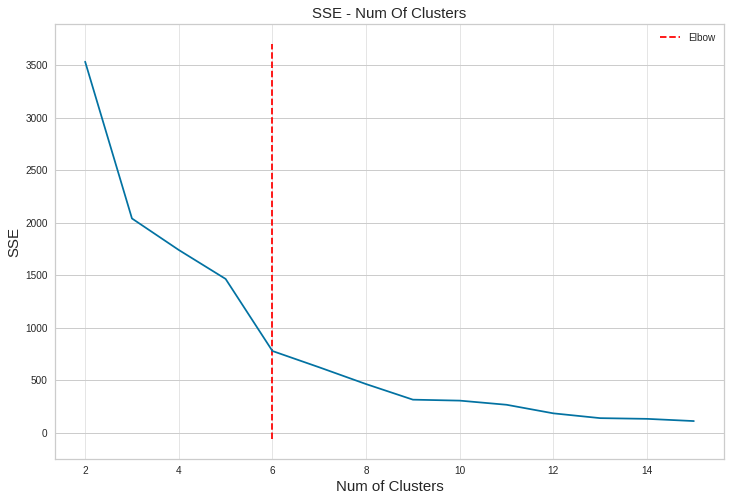

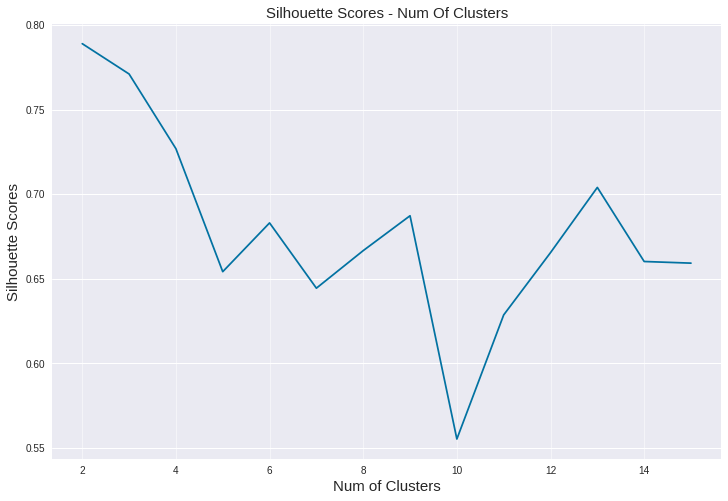

k = 2||  SSE = 1739.02|| Silhouette Score = 0.7268353102317676
k = 3||  SSE = 1463.31|| Silhouette Score = 0.6541179217699964
k = 4||  SSE = 776.78|| Silhouette Score = 0.682954614607918
k = 5||  SSE = 621.45|| Silhouette Score = 0.6443641778467071
k = 6||  SSE = 461.72|| Silhouette Score = 0.6665704380228953
k = 7||  SSE = 313.35|| Silhouette Score = 0.6871881793602053
k = 8||  SSE = 304.22|| Silhouette Score = 0.5551835979746476
k = 9||  SSE = 264.73|| Silhouette Score = 0.628556673416449
k = 10||  SSE = 182.98|| Silhouette Score = 0.6653861908386994
k = 11||  SSE = 137.33|| Silhouette Score = 0.7039291734035734
k = 12||  SSE = 130.58|| Silhouette Score = 0.6601398345289656
k = 13||  SSE = 109.51|| Silhouette Score = 0.6591720722720539


In [ ]:
features = ['latitude', 'longitude']
centers, ssh, sse = getKMeans_(location_coord_rdd_DF, features, 16,  True)

Eseguiamo il k-means con k = 6

In [ ]:
features = ['latitude', 'longitude']

# trasformo in vector
assembler = VectorAssembler(inputCols = features, outputCol="features")
transformed = assembler.transform(location_coord_rdd_DF)

In [ ]:
# train the model
kmeans = KMeans(featuresCol='features', k=6).setSeed(1)
model = kmeans.fit(transformed)

In [ ]:
# make clustering 
df_location = model.transform(transformed)

In [ ]:
df_location.show()

+-----------------+-------------------+------------------+--------------------+----------+
|           Adress|           latitude|         longitude|            features|prediction|
+-----------------+-------------------+------------------+--------------------+----------+
|           Albury|        -36.0804766|       146.9162795|[-36.0804766,146....|         5|
|    Coffs Harbour|        -30.2962407|       153.1135293|[-30.2962407,153....|         0|
|   Norfolk Island|        -29.0289575| 167.9587289126371|[-29.0289575,167....|         0|
|           Sydney|        -33.8548157|       151.2164539|[-33.8548157,151....|         0|
|   Sydney Airport|         -33.935309|       151.1655825|[-33.935309,151.1...|         0|
|      Williamtown|            -32.815|       151.8427778|[-32.815,151.8427...|         0|
|       Wollongong|        -34.4243941|         150.89385|[-34.4243941,150....|         0|
|         Canberra|        -35.2975906|       149.1012676|[-35.2975906,149....|         0|

In [ ]:
df_location_save = df_location.drop("features")

In [ ]:
df_location_save.toPandas().to_csv('drive/MyDrive/DDAM/Australia Rain/australia_clusters_geo.csv', header=True, index=False)

In [ ]:
# Valutazione del Cluster mediante silhouette score
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

silhouette = evaluator.evaluate(df_location)
print("--------Silhouette Score = " + str(silhouette) + "--------")

sse = model.summary.trainingCost

print("--------------------------")

# Valutazione del Cluster mediante SSE
print("--------SSE = " + str(sse)+ "--------") 

print("--------------------------")

# centroids
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

--------Silhouette Score = 0.6829580101210131--------
--------------------------
--------SSE = 776.7817408181878--------
--------------------------
Cluster Centers: 
[-32.40400632 151.76799175]
[-33.22537333 117.02923765]
[-13.46252785 131.5523231 ]
[-18.91575327 145.1748331 ]
[-26.74771987 133.91305293]
[-37.31041182 143.73901245]


In [ ]:
df_location_collect = df_location.collect()

In [ ]:
def centroids_plot(model):
  plt.figure(figsize=(30, 12))
  centers = model.clusterCenters()
  for i in range(0, len(centers)):
      plt.plot(centers[i], marker='o', label='Cluster %s' % i)
  plt.tick_params(axis='both', which='major', labelsize=22)
  plt.xticks(ticks = range(0, len(features)), labels = features)
  plt.legend(fontsize=18)
  plt.show()

In [ ]:
color_dict = {0:"blue", 1: "red", 2: "green", 3: "purple", 4:"orange", 5:"gray"}

def plot_map(data_collect, m): 
    for location in data_collect:
      lat_lon = (location[1], location[2])
      folium.Marker(lat_lon, popup="Cluster:{0}\Location{1}".format(location[4], location[0]), icon=folium.Icon(color=color_dict[location[4]], icon="circle", prefix='fa')).add_to(m)
    return m

In [ ]:
map_australia = folium.Map(location=[meanLatitude, meanLongitude], zoom_start=5, control_scale=True)

plot_map(df_location_collect, map_australia)

#### Assegnamo ogni record al proprio cluster, in base alla location

In [ ]:
df_location_rdd = df_location.rdd.map(lambda x : (x[0],x[4])).collectAsMap()

In [ ]:
df_location_rdd

{'Adelaide': 5,
 'Albany': 1,
 'Albury': 5,
 'Alice Springs': 4,
 'Badgerys Creek': 0,
 'Ballarat': 5,
 'Bendigo': 5,
 'Brisbane': 0,
 'Cairns': 3,
 'Canberra': 0,
 'Cobar': 0,
 'Coffs Harbour': 0,
 'Dartmoor': 5,
 'Darwin': 2,
 'Gold Coast': 0,
 'Hobart': 5,
 'Katherine': 2,
 'Launceston': 5,
 'Melbourne': 5,
 'Melbourne Airport': 5,
 'Mildura': 5,
 'Moree': 0,
 'Mount Gambier': 5,
 'Mount Ginini': 0,
 'Newcastle': 0,
 'Nhil': 5,
 'Norah Head': 0,
 'Norfolk Island': 0,
 'Nuriootpa': 5,
 'Pearce RAAF': 1,
 'Penrith': 0,
 'Perth': 1,
 'Perth Airport': 1,
 'Portland': 5,
 'Richmond': 3,
 'Sale': 5,
 'Salmon Gums': 1,
 'Sydney': 0,
 'Sydney Airport': 0,
 'Townsville': 3,
 'Tuggeranong': 0,
 'Uluru': 4,
 'Wagga Wagga': 5,
 'Walpole': 1,
 'Watsonia': 5,
 'Williamtown': 0,
 'Witchcliffe': 1,
 'Wollongong': 0,
 'Woomera': 4}

In [ ]:
def replace_add(l):
  new_loc = location_replace(l[1])
  label = df_location_rdd[new_loc]
  new_line = [l[0]] + [new_loc] + l[2:] + [label]
  return new_line

In [ ]:
# concateniamo la label ai record e correggiamo la location
rdd_rain_no_header_label = rdd_rain_no_header.map(lambda l : replace_add(l))

In [ ]:
rdd_rain_no_header_label.take(1)

[['01/12/2008',
  'Albury',
  '13.4',
  '22.9',
  '0.6',
  '3.2',
  '5.6',
  'W',
  '44.0',
  'W',
  'WNW',
  '20.0',
  '24.0',
  '71.0',
  '22.0',
  '1007.7',
  '1007.1',
  '8.0',
  '2.0',
  '16.9',
  '21.8',
  'No',
  '0.0',
  'No',
  '12',
  'Winter',
  'New South Wales',
  5]]

In [ ]:
columns_new = ['Date','Location','MinTemp','MaxTemp','Rainfall','Evaporation','Sunshine','WindGustDir','WindGustSpeed','WindDir9am','WindDir3pm','WindSpeed9am','WindSpeed3pm',
 'Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','Cloud9am','Cloud3pm','Temp9am','Temp3pm','RainToday','RISK_MM','RainTomorrow','Month', "Season", "Region", "Cluster_id"]

In [ ]:
cat_cols = ["Date", "Location", "WindGustDir", "WindDir9am", "WindDir3pm", "RainTomorrow", "RainToday", "Cluster_id", 'Month', "Season", "Region"]

In [ ]:
rain_label_DF = rdd_rain_no_header_label.toDF(columns_new)

In [ ]:
rain_label_DF.show()

+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+-------+------------+-----+------+---------------+----------+
|      Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RISK_MM|RainTomorrow|Month|Season|         Region|Cluster_id|
+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+-------+------------+-----+------+---------------+----------+
|01/12/2008|  Albury|   13.4|   22.9|     0.6|        3.2|     5.6|          W|         44.0|         W|       WNW|

In [ ]:
col_to_float = [i for i in rain_label_DF.columns if i not in cat_cols]

In [ ]:
for attr in col_to_float:
  rain_label_DF = rain_label_DF.withColumn(attr, col(attr).cast(FloatType()))

In [ ]:
print("Dimensione dei Clusters")
rain_label_DF.groupBy('Cluster_id').count().orderBy('count', ascending=False).show()

Dimensione dei Clusters
+----------+-----+
|Cluster_id|count|
+----------+-----+
|         0|50877|
|         5|49345|
|         1|20706|
|         3| 8972|
|         4| 7542|
|         2| 4751|
+----------+-----+



In [ ]:
lst_features = []
for i in rain_label_DF.columns:
  if i not in ['Cluster_id']:
    lst_features.append(i)

In [ ]:
clusters = [0, 1, 2, 3, 4, 5]

# creiamo un dataframe per ogni cluster generato
df_cluster = {}
for i in clusters:
  df_cluster[i] = rain_label_DF.filter(rain_label_DF["Cluster_id"] == i).select(lst_features)

In [ ]:
lst_features_not = []
for i in lst_features:
  if i not in ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow', 'Month', 'Season', 'Region']:
    lst_features_not.append(i)

In [ ]:
print("**************Statistiche su variabili numeriche********************")
for i in clusters:
  print("CLUSTER " + str(i))
  for j in lst_features_not:
    df_cluster[i].select(j).summary().show()
    
  print("*****************************************************************************")

**************Statistiche su variabili numeriche********************
CLUSTER 0
+-------+------------------+
|summary|           MinTemp|
+-------+------------------+
|  count|             50464|
|   mean|12.865985653878438|
| stddev| 6.368444542082723|
|    min|              -8.5|
|    25%|               8.7|
|    50%|              13.6|
|    75%|              17.9|
|    max|              29.7|
+-------+------------------+

+-------+-----------------+
|summary|          MaxTemp|
+-------+-----------------+
|  count|            50671|
|   mean|23.02570701099104|
| stddev|6.452604653706484|
|    min|             -4.8|
|    25%|             19.1|
|    50%|             23.0|
|    75%|             27.1|
|    max|             47.3|
+-------+-----------------+

+-------+------------------+
|summary|          Rainfall|
+-------+------------------+
|  count|             50144|
|   mean| 2.886243620100351|
| stddev|10.029138706692523|
|    min|               0.0|
|    25%|               0.0|
|  

Il cluster 4 è quello con la percentuale minore di record con Yes predetto. Infatti osservando la mappa il Cluster 4 è composto dalle città che appartengono all'interno dell'Australia

In [ ]:
print("**************Statistiche su variabile binaria target********************")
for i in clusters:
  print("CLUSTER " + str(i))
  df_cluster[i].createOrReplaceTempView("tmp_"+str(i))
  tot = df_cluster[i].count()
  query = sqlCtx.sql("SELECT RainTomorrow, count(*)/"+str(tot)+" * 100 as percentage FROM tmp_"+str(i)+" GROUP BY RainTomorrow ORDER BY percentage DESC")
  query.show()

**************Statistiche su variabile binaria target********************
CLUSTER 0
+------------+-----------------+
|RainTomorrow|       percentage|
+------------+-----------------+
|          No|76.73408416376752|
|         Yes|23.26591583623248|
+------------+-----------------+

CLUSTER 1
+------------+------------------+
|RainTomorrow|        percentage|
+------------+------------------+
|          No|  76.2436008886313|
|         Yes|23.756399111368687|
+------------+------------------+

CLUSTER 2
+------------+------------------+
|RainTomorrow|        percentage|
+------------+------------------+
|          No| 76.48916017680489|
|         Yes|23.510839823195116|
+------------+------------------+

CLUSTER 3
+------------+-----------------+
|RainTomorrow|       percentage|
+------------+-----------------+
|          No|77.38519839500668|
|         Yes|22.61480160499331|
+------------+-----------------+

CLUSTER 4
+------------+-----------------+
|RainTomorrow|       percentage|
+-

In [ ]:
cat_col = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'Month', 'Season', 'Region']

In [ ]:
print("**************Statistiche su variabili categoriche********************")
for i in clusters:
    print("CLUSTER " + str(i))
    for j in cat_col:
        df_cluster[i].createOrReplaceTempView("tmp_"+str(i))
        tot = df_cluster[i].count()
        query = sqlCtx.sql("SELECT "+str(j)+", count(*)/"+str(tot)+" * 100 as percentage FROM tmp_"+str(i)+" GROUP BY "+ str(j) + " ORDER BY percentage DESC")
        query.show()

**************Statistiche su variabili categoriche********************
CLUSTER 0
+--------------+------------------+
|      Location|        percentage|
+--------------+------------------+
|      Canberra|6.7181634137232935|
|        Sydney|  6.55895591328105|
|      Brisbane| 6.213023566641115|
|Sydney Airport|5.9064017139375355|
|   Tuggeranong|  5.89264304105981|
|         Cobar|5.8729877940916335|
|    Wollongong| 5.863160170607544|
|    Gold Coast|  5.85726359651709|
|       Penrith| 5.825815201368005|
|Norfolk Island| 5.825815201368005|
|     Newcastle|5.8081254790966454|
| Coffs Harbour| 5.804194429703009|
|    Norah Head| 5.757021836979382|
|Badgerys Creek| 5.755056312282564|
|  Mount Ginini|  5.71378029364939|
|         Moree| 5.609607484718046|
|   Williamtown| 5.017984550975883|
+--------------+------------------+

+-----------+------------------+
|WindGustDir|        percentage|
+-----------+------------------+
|         NA|10.411384319043968|
|          S| 7.34713131670499

In [ ]:
for i in clusters:
  df_cluster[i] = df_cluster[i].withColumn("RainTomorrow", when(df_cluster[i]["RainTomorrow"] == "Yes", 1).otherwise(0))
  df_cluster[i] = df_cluster[i].withColumn("RainToday", when(df_cluster[i]["RainToday"] == "Yes", 1).otherwise(0))
  df_cluster[i] = df_cluster[i].withColumnRenamed("RainTomorrow","y")

Salvataggio dei dataframe per backup

In [ ]:
for i in clusters:
  df_cluster[i].toPandas().to_csv('drive/MyDrive/DDAM/Australia Rain/Martina/Cluster_KMeans(Geo)/KMeans_C'+str(i+1)+'_geo.csv', header=True)

In [ ]:
cluster_dt = df_cluster.copy()

## Classificazione

Correlazioni con la variabile Target RainTomorrow superiori allo 0.15

Attributi per classificazione:

* Rainfall 0.23
* Sunshine -0.45
* WindGustSpeed 0.23
* Humidity3pm 0.44
* Pressure9am -0.24
* Cloud3pm 0.38
* RainToday

In [ ]:
features_to_select = ['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure9am', 'Cloud3pm', 'RainToday']

In [ ]:
def split_clusters(dt_clust, train_test_clusters, features_to_select, model_pca, i):
  # trasformo in vector
  assembler = VectorAssembler(inputCols = features_to_select, outputCol="features_to_scale", handleInvalid = "skip")
  trasformed_i = assembler.transform(dt_clust)

  # applico il modello di pre-processing (MinMax, RobustScaler, ScandarScaler etc...)
  #trasformedModel_i = model_scale.fit(trasformed_i)
  #trasformed_i = trasformedModel_i.transform(trasformed_i)
  # applico pca 
  trasformedModel_i = model_pca.fit(trasformed_i)
  trasformed_i = trasformedModel_i.transform(trasformed_i)

  print("*********************")
  print("SPLIT FOR CLUSTER " + str(i+1))
  # split in train e test
  train_test = {}
  train, test = trasformed_i.randomSplit([0.7, 0.3], seed = 42)
  train_test["train"] = train
  train_test["test"] = test
  train_test_clusters[i] = train_test

  return train_test_clusters

In [ ]:
# modello PCA e variabili da usare per la classificazione
model_scale = StandardScaler(inputCol='features_to_scale', outputCol='standardized')
model_pca = PCA(k = 3, inputCol="features_to_scale", outputCol="features")
train_test_clusters = {}
for i in clusters:
  train_test_clusters = split_clusters(df_cluster[i], train_test_clusters, features_to_select, model_pca, i)

*********************
SPLIT FOR CLUSTER 1
*********************
SPLIT FOR CLUSTER 2
*********************
SPLIT FOR CLUSTER 3
*********************
SPLIT FOR CLUSTER 4
*********************
SPLIT FOR CLUSTER 5
*********************
SPLIT FOR CLUSTER 6


### Decision Tree

In [ ]:
# funzione per il backup dei best_best_hypers, in quanto richiede molto tempo ottenerli con la CrossValidation
def backup_best_hypers(best_hypers):
    list_best_hypers = []
    for i in range(0, 5):
        dict_i ={}
        dict_i["Cluster"] = i
        dict_i["maxDepth"] = best_hypers[i]["maxDepth"]
        dict_i["maxBins"] = best_hypers[i]["maxBins"]
        #dict_i["BestModel"] = best_hypers[i]["BestModel"]
        list_best_hypers.append(dict_i)
    df_best_hypers = spark.createDataFrame(list_best_hypers)
    df_best_hypers.write.format("csv").save("drive/My Drive/DDAM/Australia Rain/Martina/DT_best_hypersPCA.csv", header = True)

In [ ]:
def get_backup_best_hypers(model):
  best_hypers_df = spark.read.load("drive/My Drive/DDAM/Australia Rain/Martina/DT_best_hypers"+model+".csv", format="csv", sep=",", inferSchema="true", header="true").drop("_c0")    
  return best_hypers_df

In [ ]:
def CrossValidation_DT(best_hypers, train_test_clusters, i):
  # creiamo il modello DecisionTree
  model_DT = DecisionTreeClassifier(labelCol="y", featuresCol="features", seed= 2)
  
  # paramGrid
  paramGrid = (ParamGridBuilder()
          #.addGrid(model_DT.impurity, ["entropy", "gini"])
          .addGrid(model_DT.maxDepth, [x for x in range(2, 30, 2)])
          .addGrid(model_DT.maxBins, [x for x in range(2, 30, 2)]).build())
  
  # Evaluate model
  model_evaluator = BinaryClassificationEvaluator(labelCol='y', rawPredictionCol="prediction")
  print("CROSS VALIDATION FOR CLUSTER " + str(i) )
  # 3-fold CrossValidator
  cross_validator = CrossValidator(estimator = model_DT,
                        estimatorParamMaps = paramGrid,
                        evaluator = model_evaluator,
                        numFolds = 5)
  

  cv_model = cross_validator.fit(train_test_clusters[i]["train"])
  
  bestModel = cv_model.bestModel
  extract_par = bestModel.extractParamMap()
  best_parameters = {}
  #best_parameters["impurity"] = extract_par[bestModel.getParam("impurity")] "entropy"
  best_parameters["maxDepth"] = extract_par[bestModel.getParam("maxDepth")]
  best_parameters["maxBins"] = extract_par[bestModel.getParam("maxBins")]
  best_parameters["BestModel"] = bestModel
  print("BEST HYPERPARAMETERS FOR CLUSTER " + str(i))
  print(best_parameters)
  print("*********************")
  best_hypers[i] = best_parameters
  return best_hypers

In [ ]:
# miglior iperparametri di DT trovati grazie alla CrossValidation
i = [0, 1, 2, 3, 4, 5]
best_hypers = {}
for i in clusters:
  print("*********************PCA*********************")
  best_hypers = CrossValidation_DT(best_hypers, train_test_clusters, i)

*********************PCA*********************
CROSS VALIDATION FOR CLUSTER 0
BEST HYPERPARAMETERS FOR CLUSTER 0
{'maxDepth': 8, 'maxBins': 6, 'BestModel': DecisionTreeClassificationModel: uid=DecisionTreeClassifier_2c8c1aef17c1, depth=8, numNodes=49, numClasses=2, numFeatures=3}
*********************
*********************PCA*********************
CROSS VALIDATION FOR CLUSTER 1
BEST HYPERPARAMETERS FOR CLUSTER 1
{'maxDepth': 6, 'maxBins': 10, 'BestModel': DecisionTreeClassificationModel: uid=DecisionTreeClassifier_60f1d2082c69, depth=6, numNodes=45, numClasses=2, numFeatures=3}
*********************
*********************PCA*********************
CROSS VALIDATION FOR CLUSTER 2
BEST HYPERPARAMETERS FOR CLUSTER 2
{'maxDepth': 4, 'maxBins': 4, 'BestModel': DecisionTreeClassificationModel: uid=DecisionTreeClassifier_8b492699d89d, depth=4, numNodes=9, numClasses=2, numFeatures=3}
*********************
*********************PCA*********************
CROSS VALIDATION FOR CLUSTER 3
BEST HYPERPARAMET

In [ ]:
backup_best_hypers(best_hypers)

In [ ]:
def DecisionTree_(predictions, train_test_cluster, best_hyper, i):
  # creiamo il modello DecisionTree
  #model_DT = DecisionTreeClassifier(labelCol="y", featuresCol="features", impurity='entropy', seed= 2)
  #bestModel_i = model_DT.setMaxDepth(best_hyper['maxDepth'])
  #bestModel_i = bestModel_i.setMaxBins(best_hyper['maxBins'])
  bestModel_i = best_hyper["BestModel"]
  #model = bestModel_i.fit(train_test_cluster["train"])
  prediction = bestModel_i.transform(train_test_cluster["test"])
  predictions[i] = prediction
  return predictions

In [ ]:
predictions = {}
for i in clusters:
  predictions = DecisionTree_(predictions, train_test_clusters[i], best_hypers[i], i)

In [ ]:
for i in clusters:
  print("*****CLUSTER"+str(i+1)+"*****")
  predictions[i].select("y","prediction").show(10)

*****CLUSTER1*****
+---+----------+
|  y|prediction|
+---+----------+
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  1|       1.0|
|  0|       0.0|
|  1|       1.0|
|  0|       0.0|
|  1|       0.0|
|  0|       0.0|
+---+----------+
only showing top 10 rows

*****CLUSTER2*****
+---+----------+
|  y|prediction|
+---+----------+
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       1.0|
|  0|       0.0|
|  0|       0.0|
+---+----------+
only showing top 10 rows

*****CLUSTER3*****
+---+----------+
|  y|prediction|
+---+----------+
|  0|       1.0|
|  0|       0.0|
|  0|       0.0|
|  1|       1.0|
|  0|       1.0|
|  1|       1.0|
|  0|       0.0|
|  1|       1.0|
|  0|       1.0|
|  0|       1.0|
+---+----------+
only showing top 10 rows

*****CLUSTER4*****
+---+----------+
|  y|prediction|
+---+----------+
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  1|       0

In [ ]:
from tabulate import tabulate
def calculateMetrics(predictions, i, evaluator, evaluator2):
  TP = predictions.filter((predictions['prediction'] == 1.0) & (predictions['y'] == 1)).count() +0.1 # evita ZeroDivisionError
  FP = predictions.filter((predictions['prediction'] == 1.0) & (predictions['y'] == 0)).count()
  TN = predictions.filter((predictions['prediction'] == 0.0) & (predictions['y'] == 0)).count()
  FN = predictions.filter((predictions['prediction'] == 0.0) & (predictions['y'] == 1)).count()


  print(tabulate([['Area under ROC curve:', evaluator.evaluate(predictions)],
                    ['Area under PR curve:', evaluator2.evaluate(predictions)],
                    ['Accuracy:', (TP+TN)/(TP+TN+FP+FN)], 
                    ['Precision:', TP/(TP+FP)], 
                    ['Recall:', TP/(TP+FN)], 
                    ['F-measure:', (2*TP)/(2*TP+FN+FP)]], headers=['Cluster {}'.format(i), ''], tablefmt='orgtbl'))

In [ ]:
# Evaluator per ROC curve
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                                labelCol='y',
                                                metricName="areaUnderROC")

# Evaluator per PR curve
evaluator2 = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                                labelCol='y',
                                                metricName="areaUnderPR")

In [ ]:
print('+-------------+')
print('|Decision Tree|')
print('+-------------+')

for i in clusters:
  calculateMetrics(predictions[i], i, evaluator, evaluator2 )

+-------------+
|Decision Tree|
+-------------+
| Cluster 0             |          |
|-----------------------+----------|
| Area under ROC curve: | 0.704489 |
| Area under PR curve:  | 0.541205 |
| Accuracy:             | 0.827264 |
| Precision:            | 0.65219  |
| Recall:               | 0.482905 |
| F-measure:            | 0.554924 |
| Cluster 1             |          |
|-----------------------+----------|
| Area under ROC curve: | 0.734552 |
| Area under PR curve:  | 0.617382 |
| Accuracy:             | 0.849692 |
| Precision:            | 0.739434 |
| Recall:               | 0.523431 |
| F-measure:            | 0.61296  |
| Cluster 2             |          |
|-----------------------+----------|
| Area under ROC curve: | 0.806518 |
| Area under PR curve:  | 0.588117 |
| Accuracy:             | 0.836678 |
| Precision:            | 0.638148 |
| Recall:               | 0.748292 |
| F-measure:            | 0.688845 |
| Cluster 3             |          |
|-----------------------+--

### Random Forest

In [ ]:
def CrossValidation_RF(best_hypers, train_test_clusters, i):
  # creiamo il modello DecisionTree
  model_RF = RandomForestClassifier(labelCol="y", featuresCol="features", seed= 42)
  
  # paramGrid
  paramGrid = ParamGridBuilder() \
    .addGrid(model_RF.maxDepth, [  x for x in range( 2, 15, 3 )   ]) \
    .addGrid(model_RF.numTrees, [  x for x in range( 2, 15, 3 )   ]) \
    .build()
  
  # Evaluate model
  model_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                                labelCol='y',
                                                metricName="areaUnderROC")
  
  print("CROSS VALIDATION FOR CLUSTER " + str(i) )
  # 5-fold CrossValidator
  cross_validator = CrossValidator(estimator = model_RF,
                        estimatorParamMaps = paramGrid,
                        evaluator = model_evaluator,
                        numFolds = 5)
  
  cv_model = cross_validator.fit(train_test_clusters[i]["train"])
  
  bestModel = cv_model.bestModel
  extract_par = bestModel.extractParamMap()
  best_parameters = {}
  #best_parameters["impurity"] = extract_par[bestModel.getParam("impurity")] "entropy"
  best_parameters["maxDepth"] = extract_par[bestModel.getParam("maxDepth")]
  best_parameters["numTrees"] = extract_par[bestModel.getParam("numTrees")]
  best_parameters["BestModel"] = bestModel
  print("BEST HYPERPARAMETERS FOR CLUSTER " + str(i))
  print(best_parameters)
  print("*********************")
  best_hypers[i] = best_parameters
  return best_hypers

In [ ]:
from  pyspark.ml.classification import RandomForestClassifier, LogisticRegression
# miglior iperparametri di RF trovati grazie alla CrossValidation
best_hypers_RF = {}
for i in clusters:
  print("*********************PCA*********************")
  best_hypers_RT = CrossValidation_RF(best_hypers_RF, train_test_clusters, i)

*********************PCA*********************
CROSS VALIDATION FOR CLUSTER 0
BEST HYPERPARAMETERS FOR CLUSTER 0
{'maxDepth': 8, 'numTrees': 11, 'BestModel': RandomForestClassificationModel: uid=RandomForestClassifier_b6ab2f232dca, numTrees=11, numClasses=2, numFeatures=3}
*********************
*********************PCA*********************
CROSS VALIDATION FOR CLUSTER 1
BEST HYPERPARAMETERS FOR CLUSTER 1
{'maxDepth': 8, 'numTrees': 8, 'BestModel': RandomForestClassificationModel: uid=RandomForestClassifier_389696b0d7a6, numTrees=8, numClasses=2, numFeatures=3}
*********************
*********************PCA*********************
CROSS VALIDATION FOR CLUSTER 2
BEST HYPERPARAMETERS FOR CLUSTER 2
{'maxDepth': 2, 'numTrees': 2, 'BestModel': RandomForestClassificationModel: uid=RandomForestClassifier_7e1f27b6c1c1, numTrees=2, numClasses=2, numFeatures=3}
*********************
*********************PCA*********************
CROSS VALIDATION FOR CLUSTER 3
BEST HYPERPARAMETERS FOR CLUSTER 3
{'maxDe

In [ ]:
def RandomForest_(predictions, train_test_cluster, best_hyper, i):
  # creiamo il modello RandomForest
  #model_RF = DecisionTreeClassifier(labelCol="y", featuresCol="features", impurity='entropy', seed= 2)
  #bestModel_i = model_DT.setMaxDepth(best_hyper['maxDepth'])
  #bestModel_i = bestModel_i.setMaxBins(best_hyper['maxBins'])
  #bestModel_i = best_hyper["BestModel"]
  bestModel_i = best_hyper["BestModel"]
  #model = bestModel_i.fit(train_test_cluster["train"])
  prediction = bestModel_i.transform(train_test_cluster["test"])
  predictions[i] = prediction
  return predictions

In [ ]:
predictions = {}
for i in clusters:
  predictions = RandomForest_(predictions, train_test_clusters[i], best_hypers_RT[i], i)

In [ ]:
for i in clusters:
  print("*****CLUSTER"+str(i+1)+"*****")
  predictions[i].select("y","prediction").show(10)

*****CLUSTER1*****
+---+----------+
|  y|prediction|
+---+----------+
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  1|       1.0|
|  0|       0.0|
|  1|       1.0|
|  0|       0.0|
|  1|       0.0|
|  0|       0.0|
+---+----------+
only showing top 10 rows

*****CLUSTER2*****
+---+----------+
|  y|prediction|
+---+----------+
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       1.0|
|  0|       1.0|
|  0|       0.0|
+---+----------+
only showing top 10 rows

*****CLUSTER3*****
+---+----------+
|  y|prediction|
+---+----------+
|  0|       1.0|
|  0|       0.0|
|  0|       0.0|
|  1|       1.0|
|  0|       1.0|
|  1|       1.0|
|  0|       0.0|
|  1|       1.0|
|  0|       1.0|
|  0|       1.0|
+---+----------+
only showing top 10 rows

*****CLUSTER4*****
+---+----------+
|  y|prediction|
+---+----------+
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  1|       0

In [ ]:
# Evaluator per ROC curve
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                                labelCol='y',
                                                metricName="areaUnderROC")

# Evaluator per PR curve
evaluator2 = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                                labelCol='y',
                                                metricName="areaUnderPR")

In [ ]:
print('+-------------+')
print('|Random Forest|')
print('+-------------+')

for i in clusters:
  calculateMetrics(predictions[i], i, evaluator, evaluator2)

+-------------+
|Random Forest|
+-------------+
| Cluster 0             |          |
|-----------------------+----------|
| Area under ROC curve: | 0.681701 |
| Area under PR curve:  | 0.571547 |
| Accuracy:             | 0.832403 |
| Precision:            | 0.717524 |
| Recall:               | 0.409712 |
| F-measure:            | 0.521591 |
| Cluster 1             |          |
|-----------------------+----------|
| Area under ROC curve: | 0.726299 |
| Area under PR curve:  | 0.629422 |
| Accuracy:             | 0.850896 |
| Precision:            | 0.76426  |
| Recall:               | 0.497838 |
| F-measure:            | 0.602929 |
| Cluster 2             |          |
|-----------------------+----------|
| Area under ROC curve: | 0.745639 |
| Area under PR curve:  | 0.614148 |
| Accuracy:             | 0.841022 |
| Precision:            | 0.719023 |
| Recall:               | 0.561309 |
| F-measure:            | 0.630452 |
| Cluster 3             |          |
|-----------------------+--

### Logistic Regression

In [ ]:
def CrossValidation_LR(best_hypers, train_test_clusters, i):
  # creiamo il modello LogisticRegression
  model_LR = LogisticRegression(featuresCol = 'features', labelCol = 'y')

  # paramGrid
  paramGrid = ParamGridBuilder() \
    .addGrid(model_LR.maxIter, [x for x in range(1,30,5)])\
    .addGrid(model_LR.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()
  
  # Evaluate model
  model_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                                labelCol='y',
                                                metricName="areaUnderROC")
  
  print("CROSS VALIDATION FOR CLUSTER " + str(i) )
  # 5-fold CrossValidator
  cross_validator = CrossValidator(estimator = model_LR,
                        estimatorParamMaps = paramGrid,
                        evaluator = model_evaluator,
                        numFolds = 5)
  
  cv_model = cross_validator.fit(train_test_clusters[i]["train"])
  
  bestModel = cv_model.bestModel
  extract_par = bestModel.extractParamMap()
  best_parameters = {}
  #best_parameters["impurity"] = extract_par[bestModel.getParam("impurity")] "entropy"
  best_parameters["maxIter"] = extract_par[bestModel.getParam("maxIter")]
  best_parameters["elasticNetParam"] = extract_par[bestModel.getParam("elasticNetParam")]
  best_parameters["BestModel"] = bestModel
  print("BEST HYPERPARAMETERS FOR CLUSTER " + str(i))
  print(best_parameters)
  print("*********************")
  best_hypers[i] = best_parameters
  return best_hypers

In [ ]:
# miglior iperparametri di LR trovati grazie alla CrossValidation
best_hypers_LR = {}
for i in clusters:
  print("*********************PCA*********************")
  best_hypers_LR = CrossValidation_LR(best_hypers_LR, train_test_clusters, i)

*********************PCA*********************
CROSS VALIDATION FOR CLUSTER 0
BEST HYPERPARAMETERS FOR CLUSTER 0
{'maxIter': 6, 'elasticNetParam': 0.5, 'BestModel': LogisticRegressionModel: uid=LogisticRegression_75e6008263b2, numClasses=2, numFeatures=3}
*********************
*********************PCA*********************
CROSS VALIDATION FOR CLUSTER 1
BEST HYPERPARAMETERS FOR CLUSTER 1
{'maxIter': 6, 'elasticNetParam': 0.0, 'BestModel': LogisticRegressionModel: uid=LogisticRegression_93c6dc3f3548, numClasses=2, numFeatures=3}
*********************
*********************PCA*********************
CROSS VALIDATION FOR CLUSTER 2
BEST HYPERPARAMETERS FOR CLUSTER 2
{'maxIter': 6, 'elasticNetParam': 0.0, 'BestModel': LogisticRegressionModel: uid=LogisticRegression_1d7ea0c3dd5c, numClasses=2, numFeatures=3}
*********************
*********************PCA*********************
CROSS VALIDATION FOR CLUSTER 3
BEST HYPERPARAMETERS FOR CLUSTER 3
{'maxIter': 6, 'elasticNetParam': 0.0, 'BestModel': Logis

In [ ]:
def LogisticRegression_(predictions, train_test_cluster, best_hyper, i):
  # creiamo il modello RandomForest
  #model_RF = DecisionTreeClassifier(labelCol="y", featuresCol="features", impurity='entropy', seed= 2)
  #bestModel_i = model_DT.setMaxDepth(best_hyper['maxDepth'])
  #bestModel_i = bestModel_i.setMaxBins(best_hyper['maxBins'])
  #bestModel_i = best_hyper["BestModel"]
  bestModel_i = best_hyper["BestModel"]
  #model = bestModel_i.fit(train_test_cluster["train"])
  prediction = bestModel_i.transform(train_test_cluster["test"])
  predictions[i] = prediction
  return predictions

In [ ]:
predictions = {}
for i in clusters:
  predictions = LogisticRegression_(predictions, train_test_clusters[i], best_hypers_LR[i], i)

In [ ]:
for i in clusters:
  print("*****CLUSTER"+str(i+1)+"*****")
  predictions[i].select("y","prediction").show(10)

*****CLUSTER1*****
+---+----------+
|  y|prediction|
+---+----------+
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  1|       1.0|
|  0|       0.0|
|  1|       0.0|
|  0|       0.0|
|  1|       0.0|
|  0|       0.0|
+---+----------+
only showing top 10 rows

*****CLUSTER2*****
+---+----------+
|  y|prediction|
+---+----------+
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       1.0|
|  0|       0.0|
|  0|       0.0|
+---+----------+
only showing top 10 rows

*****CLUSTER3*****
+---+----------+
|  y|prediction|
+---+----------+
|  0|       1.0|
|  0|       0.0|
|  0|       0.0|
|  1|       1.0|
|  0|       1.0|
|  1|       1.0|
|  0|       0.0|
|  1|       0.0|
|  0|       0.0|
|  0|       1.0|
+---+----------+
only showing top 10 rows

*****CLUSTER4*****
+---+----------+
|  y|prediction|
+---+----------+
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  1|       0

In [ ]:
# Evaluator per ROC curve
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                                labelCol='y',
                                                metricName="areaUnderROC")

# Evaluator per PR curve
evaluator2 = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                                labelCol='y',
                                                metricName="areaUnderPR")

In [ ]:
print('+--------------------+')
print('|Logistic Regression|')
print('+--------------------+')

for i in clusters:
  calculateMetrics(predictions[i], i, evaluator, evaluator2)

+--------------------+
|Logistic Regression|
+--------------------+
| Cluster 0             |          |
|-----------------------+----------|
| Area under ROC curve: | 0.684503 |
| Area under PR curve:  | 0.568706 |
| Accuracy:             | 0.832252 |
| Precision:            | 0.710679 |
| Recall:               | 0.417844 |
| F-measure:            | 0.526269 |
| Cluster 1             |          |
|-----------------------+----------|
| Area under ROC curve: | 0.734114 |
| Area under PR curve:  | 0.648203 |
| Accuracy:             | 0.856716 |
| Precision:            | 0.785063 |
| Recall:               | 0.509311 |
| F-measure:            | 0.617814 |
| Cluster 2             |          |
|-----------------------+----------|
| Area under ROC curve: | 0.748502 |
| Area under PR curve:  | 0.627383 |
| Accuracy:             | 0.845365 |
| Precision:            | 0.735974 |
| Recall:               | 0.561309 |
| F-measure:            | 0.636883 |
| Cluster 3             |          |
|------